<a href="https://colab.research.google.com/github/jatins13/Presence-Detection-Using-WiFi-CSI/blob/main/Presence_Detection_LSTM_Cross.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import pandas as pd
import numpy as np
import glob
from google.colab import drive
from pathlib import Path
from math import sqrt
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

drive.mount('/content/gdrive')


data_url = '/content/gdrive/MyDrive/Presence_detection_data_CSI/Train1/'

Mounted at /content/gdrive


# Filters


In [ ]:
from scipy import signal
def lowpass(csi_vec: np.array, cutoff: float, fs: float, order: int) -> np.array:
    nyq = 0.5*fs
    normal_cutoff = cutoff/nyq
    b, a = signal.butter(order, normal_cutoff, btype="low", analog=False)
    return signal.filtfilt(b, a, csi_vec)

def bandpass(csi_vec: np.array, low_cut: float, high_cut: float, fs: float, order: int) -> np.array:
    nyq = 0.5*fs
    b, a = signal.butter(order, [low_cut/nyq, high_cut/nyq], btype="band", analog=False)
    return signal.filtfilt(b, a, csi_vec)

#Original implementation from whyrlpool.
#Runs slightly slower than Pandas implementation.
def hampel(csi: np.array, k: int=3, nsigma: int=3) -> np.array:
    index = 0
    csi = csi.copy()
    for x in csi:
        y = 0
        if index <= k:
            #Special case, first few samples.
            y = k
        elif index+k > len(csi):
            #Special case, last few samples
            y = -k

        index += y
        stdev = np.std(csi[index-k:index+k])
        median = np.median(csi[index-k:index+k])
        index -= y

        if abs(x-median) > nsigma * stdev:
            csi[index] = median
        index += 1

    return csi

def running_mean(x: np.array, N: int) -> np.array:
    return pd.Series(x).rolling(window=N, min_periods=1, center=True).mean().to_numpy()

def running_stdev(x: np.array, N: int) -> np.array:
    return pd.Series(x).rolling(window=N, min_periods=1, center=True).std().to_numpy()

def running_variance(x: np.array, N: int) -> np.array:
    return pd.Series(x).rolling(window=N, min_periods=1, center=True).var().to_numpy()

# Read File Function


In [ ]:
def read_csv( data_url, window_size, step_size, scaler):


  data_np_windowed = []
  data_wp_windowed = []

  data_np = []
  data_wp = []

  label_data_np = []
  label_data_wp = []

  file_list  = glob.glob(data_url+'*.csv')
  for file_name in file_list:
    print(file_name)
    if (file_name.find('NP')!=-1):
      noPersonData = pd.read_csv(file_name,low_memory=False)
      noPersonData = noPersonData['CSI_DATA'].values
      noPersonData = noPersonData[1800:-1800]

      for i in range(0, noPersonData.shape[0]):
        try:
          st = noPersonData[i]
          st = st[1:-2]
          data_array = [int(s) for s in st.split(' ')]
          data_array = data_array[12:64] + data_array[66:-10]
          # print(data_array)
          data_array_mag = []
          for k in range(0,104,2):
            data_array_mag.append(sqrt(data_array[k]**2 + data_array[k+1]**2))
          # data_array_mag = running_mean(data_array_mag,5)
          # data_array_mag = scaler.fit_transform(data_array_mag)
          data_np.append(data_array_mag)
        # Pre-processing
        # data_np_window = lowpass(data_np_window,10,190,3)
        # data_np_windowed.append(data_np_window)
          # label_data_np.append(0)
        except:
          continue
    else:
      withPersonData = pd.read_csv(file_name,low_memory=False)
      withPersonData = withPersonData['CSI_DATA'].values
      withPersonData = withPersonData[1800:-1800]

      for i in range(0, withPersonData.shape[0]):
        try:
          st = withPersonData[i]
          st = st[1:-2]
          data_array = [int(s) for s in st.split(' ')]
          data_array = data_array[12:65] + data_array[67:-10]
          # print(data_array)
          data_array_mag = []
          for k in range(0,104,2):
            data_array_mag.append(sqrt(data_array[k]**2 + data_array[k+1]**2))
          # data_array_mag = running_mean(data_array_mag,5)
          # data_array_mag = scaler.fit_transform(data_array_mag)
          data_wp.append(data_array_mag)
          # Pre-processing
          # data_np_window = lowpass(data_np_window,10,190,3)
          # data_np_windowed.append(data_np_window)
          # label_data_wp.append(1)
        except:
          continue

  data_np = np.array(data_np)
  data_wp = np.array(data_wp)
  for i in range(0,52):
          data_np[:,i] = bandpass(data_np[:,i],0.2,10,192,4)
          # data_np[:,i] = running_mean(data_np[:,i],10)


  for i in range(0,52):
          data_wp[:,i] = bandpass(data_wp[:,i],0.2,10,192,4)
          # data_wp[:,i] = running_mean(data_wp[:,i],10)
  data_both = np.concatenate((data_np, data_wp), axis=0)

  data_both = scaler.fit_transform(data_both)

  data_np = data_both[0:data_np.shape[0],:]
  data_wp = data_both[data_np.shape[0]:,:]



  for start in range(0, data_np.shape[0]-window_size, step_size):
        end = start + window_size
        data_np_window= np.empty((0,52))
        for j in range(start, end):
          data_array_mag = data_np[j]
          data_np_window = np.append(data_np_window,np.array([data_array_mag]),axis = 0)
        # for i in range(0,52):
        #   data_np_window[:,i] = bandpass(data_np_window[:,i],0.2,30,192,4)
        #   data_np_window[:,i] = running_mean(data_np_window[:,i],10)
        # data_np_window = scaler.fit_transform(data_np_window)

        data_np_windowed.append(data_np_window)
        label_data_np.append([0,1])

  for start in range(0, data_wp.shape[0]-window_size, step_size):
        end = start + window_size
        data_wp_window= np.empty((0,52))
        for j in range(start, end):
          data_array_mag = data_wp[j]
          # data_array_mag = running_mean(data_array_mag,10)
          data_wp_window = np.append(data_wp_window,np.array([data_array_mag]),axis = 0)
        # for i in range(0,52):
        #   data_wp_window[:,i] = bandpass(data_wp_window[:,i],0.2,30,192,4)
        #   data_wp_window[:,i] = running_mean(data_wp_window[:,i],10)
        # data_wp_window = scaler.fit_transform(data_wp_window)
        data_wp_windowed.append(data_wp_window)
        label_data_wp.append([1,0])

  data_np = data_np_windowed
  data_wp = data_wp_windowed


  return np.array(data_np), np.array(data_wp), np.array(label_data_np), np.array(label_data_wp), scaler


# Data Extraction


In [ ]:
window_size = 200
step_size = 100
scaler = StandardScaler()
save_url = '/content/gdrive/MyDrive/Presence_detection_data_CSI/Files1/'

save_url_np = save_url + 'data_np_window_size={window}_step_size={step}.npy'.format(window = window_size, step = step_size)
save_url_np = Path(save_url_np)
save_url_wp = save_url + 'data_wp_window-size={window}_step_size={step}.npy'.format(window = window_size, step = step_size)
save_url_wp = Path(save_url_wp)

if (save_url_np.is_file() and save_url_wp.is_file()):
  data_np = np.load(save_url_np)
  data_wp = np.load(save_url_wp)
  label_data_np = np.zeros((data_np.shape[0],2))
  label_data_wp = np.zeros((data_wp.shape[0],2))
  label_data_np[:,1] = 1
  label_data_wp[:,0] = 1
else:
  file1 = 'data_np_window_size={window}_step_size={step}.npy'.format(window = window_size, step = step_size)
  file2 = 'data_wp_window-size={window}_step_size={step}.npy'.format(window = window_size, step = step_size)
  data_np, data_wp, label_data_np, label_data_wp, scaler = read_csv(data_url, window_size=window_size, step_size=step_size, scaler=scaler)
  np.save(file1,data_np)
  np.save(file2,data_wp)

/content/gdrive/MyDrive/Presence_detection_data_CSI/Train1/Copy of 10AP-1815-744-JATIN.csv
/content/gdrive/MyDrive/Presence_detection_data_CSI/Train1/Copy of 05AP-2031-744-NP.csv
/content/gdrive/MyDrive/Presence_detection_data_CSI/Train1/Copy of 10AP-1838-126-VIKASH.csv
/content/gdrive/MyDrive/Presence_detection_data_CSI/Train1/Copy of 10AP-1930-123-BITAN-MANDAL.csv
/content/gdrive/MyDrive/Presence_detection_data_CSI/Train1/Copy of 10AP-1845-126-NP.csv
/content/gdrive/MyDrive/Presence_detection_data_CSI/Train1/Copy of 10AP-1854-125-YASWANTH.csv
/content/gdrive/MyDrive/Presence_detection_data_CSI/Train1/Copy of 10AP-1959-122-NP.csv
/content/gdrive/MyDrive/Presence_detection_data_CSI/Train1/Copy of 10AP-2011-122-RAJAM.csv
/content/gdrive/MyDrive/Presence_detection_data_CSI/Train1/Copy of 10AP-1900-125-NP.csv
/content/gdrive/MyDrive/Presence_detection_data_CSI/Train1/Copy of 10AP-1912-128-KARTHEEK.csv
/content/gdrive/MyDrive/Presence_detection_data_CSI/Train1/Copy of 10AP-1943-123-NP.csv


In [ ]:
def train_test_split(data_np, data_wp, label_data_np, label_data_wp,train_portion, test_portion):
  x_train = []
  x_valid = []
  x_test = []

  y_train = []
  y_valid = []
  y_test = []

  index1 = np.random.permutation([i for i in range(data_np.shape[0])])
  index2 = np.random.permutation([i for i in range(data_wp.shape[0])])
  # print(index1)
  # print(index2)
  split_len1 = int(train_portion * data_np.shape[0])
  split_len1_2 = int((1-test_portion)* data_np.shape[0])
  split_len2 = int(train_portion * data_wp.shape[0])
  split_len2_2 = int((1-test_portion)* data_wp.shape[0])

  x_train.append(data_np[index1[:split_len1],...])
  x_train.append(data_wp[index2[:split_len2],...])

  y_train.append(label_data_np[index1[:split_len1],...])
  y_train.append(label_data_wp[index2[:split_len2],...])

  x_valid.append(data_np[index1[split_len1:split_len1_2],...])
  x_valid.append(data_wp[index2[split_len2:split_len2_2],...])

  y_valid.append(label_data_np[index1[split_len1:split_len1_2],...])
  y_valid.append(label_data_wp[index2[split_len2:split_len2_2],...])

  x_test.append(data_np[index1[split_len1_2:],...])
  x_test.append(data_wp[index2[split_len2_2:],...])

  y_test.append(label_data_np[index1[split_len1_2:],...])
  y_test.append(label_data_wp[index2[split_len2_2:],...])

  x_train = np.concatenate(x_train, axis=0)
  y_train = np.concatenate(y_train, axis=0)
  x_valid = np.concatenate(x_valid, axis=0)
  y_valid = np.concatenate(y_valid, axis=0)
  x_test = np.concatenate(x_test, axis=0)
  y_test = np.concatenate(y_test, axis=0)

  index = np.random.permutation([i for i in range(x_train.shape[0])])
  x_train = x_train[index, ...]
  y_train = y_train[index, ...]

  # x_train = x_train.reshape(x_train.shape[0],x_train.shape[1], 1)
  # x_valid = x_valid.reshape(x_valid.shape[0],x_valid.shape[1], 1)

  return x_train, y_train, x_valid, y_valid, x_test, y_test

In [ ]:
x_train, y_train, x_valid, y_valid, x_test, y_test = train_test_split(data_np, data_wp, label_data_np, label_data_wp,train_portion =0.7, test_portion = 0.1)
# y_test = np.transpose(y_test)
# y_train = np.transpose(y_train)
# y_valid = np.transpose(y_valid)
print(y_test.shape)
print(x_train.shape)


(2122, 2)
(14846, 200, 52)


In [ ]:
print(data_np.shape)
print(data_wp.shape)
# from scipy.io import savemat
# for i in range(0,10000,1000):
#   mat = {"block":data_np[i]}
#   fname = 'NP{num}.mat'.format(num=i//1000)
#   savemat(fname,mat)


(10537, 200, 52)
(10674, 200, 52)


In [ ]:
# for i in range(0,10000,1000):
#   mat = {"block":data_wp[i]}
#   fname = 'WP{num}.mat'.format(num=i//1000)
#   savemat(fname,mat)


# Data Visualizations

In [ ]:
print(data_wp.shape)
data_1 = np.concatenate(data_np,axis = 0)
print(data_1.shape)
data_1_max = np.max(data_1,axis=0)
data_1_min = np.min(data_1,axis=0)
data_1_sd = np.std(data_1,axis= 0)
data_1_avg = np.mean(data_1,axis = 0)

data_2 = np.concatenate(data_wp,axis = 0)
print(data_2.shape)
data_2_min = np.min(data_2,axis=0)
data_2_max = np.max(data_2,axis=0)
data_2_avg = np.mean(data_2,axis= 0)
data_2_sd = np.std(data_2,axis= 0)
print(data_np.shape)





(10674, 200, 52)
(2107400, 52)
(2134800, 52)
(10537, 200, 52)


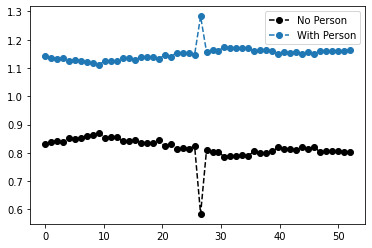

In [ ]:
plt.plot(np.linspace(0,len(data_1_sd),len(data_1_sd)),data_1_sd,'--ok',label = 'No Person')
plt.plot(np.linspace(0,len(data_2_sd),len(data_2_sd)),data_2_sd,'--o', label = 'With Person')
plt.legend()

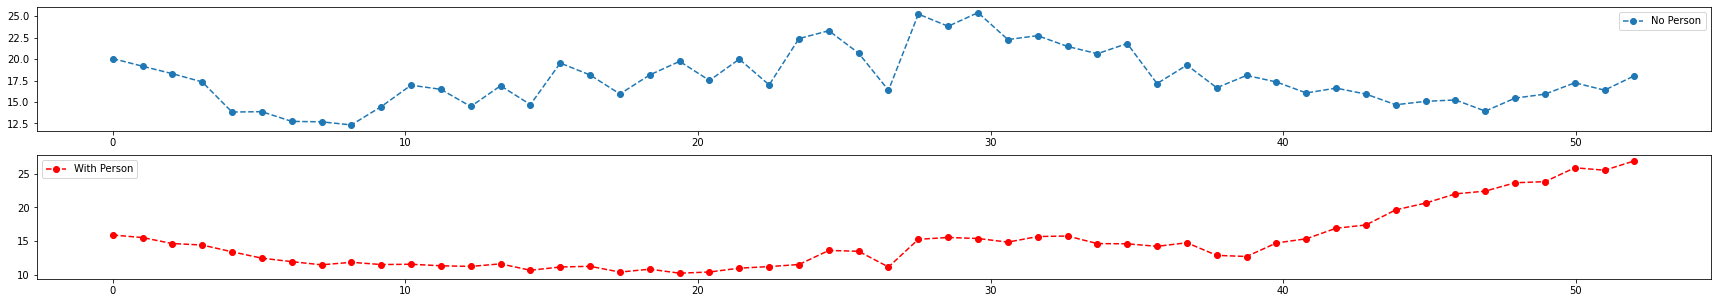

In [ ]:
plt.figure(figsize=(30,5))
plt.subplot(2,1,1)
plt.plot(np.linspace(0,len(data_1_max),len(data_1_max)),data_1_max,'--o',label='No Person')
plt.legend()
plt.subplot(2,1,2)
plt.plot(np.linspace(0,len(data_2_max),len(data_2_max)),data_2_max,'--or', label = 'With Person')
plt.legend()


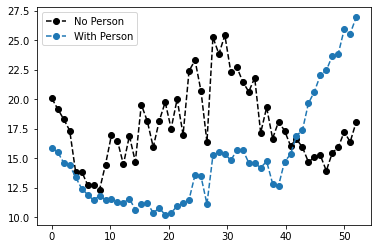

In [ ]:
plt.plot(np.linspace(0,len(data_1_max),len(data_1_max)),data_1_max,'--ok',label='No Person' )
plt.plot(np.linspace(0,len(data_2_max),len(data_2_max)),data_2_max,'--o', label='With Person')
plt.legend()

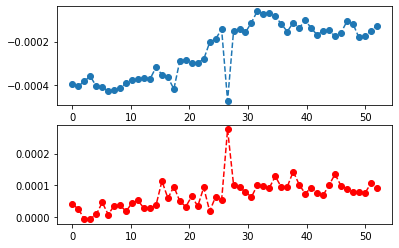

In [ ]:
plt.subplot(2,1,1)
plt.plot(np.linspace(0,len(data_1_avg),len(data_1_avg)),data_1_avg,'--o')
plt.subplot(2,1,2)
plt.plot(np.linspace(0,len(data_2_avg),len(data_2_avg)),data_2_avg,'--or')


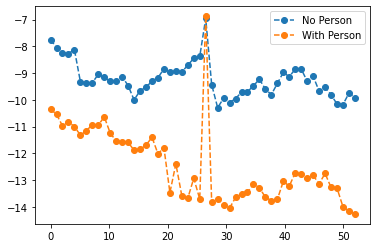

In [ ]:
plt.plot(np.linspace(0,len(data_1_min),len(data_1_min)),data_1_min,'--o',label='No Person')
plt.plot(np.linspace(0,len(data_2_min),len(data_2_min)),data_2_min,'--o',label='With Person')
plt.legend()

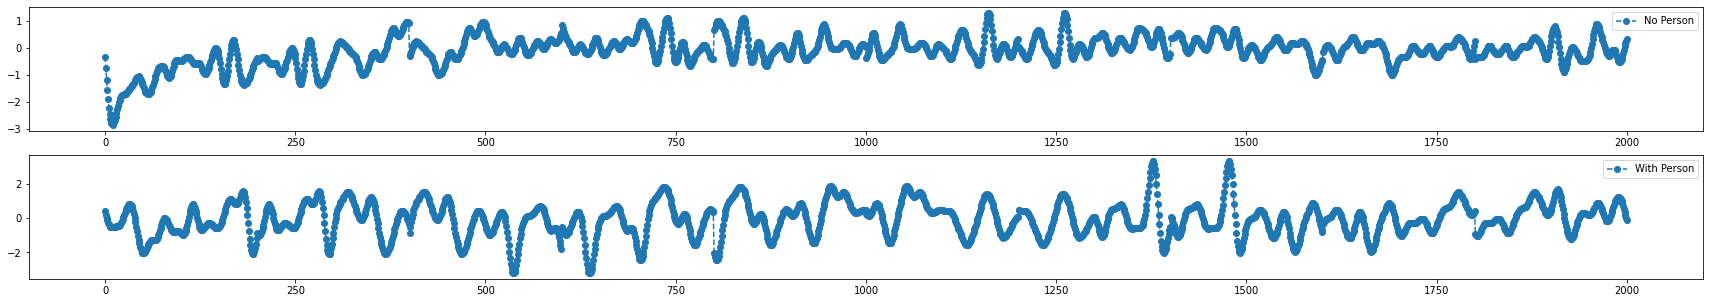

In [ ]:
plt.figure(figsize=(30,5))
plt.subplot(2,1,1)
plt.plot(np.linspace(0,2000,2000),data_1[:2000,45],'--o', label='No Person')
plt.legend()
plt.subplot(2,1,2)
plt.plot(np.linspace(0,2000,2000),data_2[:2000,45],'--o', label='With Person')
plt.legend()

In [ ]:
print(data_np.shape)
print(data_wp.shape)

print(label_data_np.shape)
print(label_data_wp)

(10537, 200, 52)
(10674, 200, 52)
(10537, 2)
[[1 0]
 [1 0]
 [1 0]
 ...
 [1 0]
 [1 0]
 [1 0]]


In [ ]:
print(x_train.shape)
print(y_test.shape)

(14846, 200, 52)
(2122, 2)


# Dense Model


In [ ]:
#Defining the model
batch_size = 128
num_classes = 2
epochs = 40
input_shape = (window_size,52)

import keras
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Bidirectional
# from keras.utils import to_categorical
import tensorflow as tf


model = Sequential()

model.add(LSTM(100, input_shape=input_shape))
model.add(Dropout(0.3))
model.add(Dense(64, activation='tanh'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='tanh'))
model.add(Dropout(0.3))
model.add(Dense(16, activation='tanh'))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               61200     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                6464      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)               

# Without Cross-Validation


In [ ]:
model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy'])

history = model.fit(
          x_train,
          y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_valid, y_valid),
          callbacks = callbacks
        )

Epoch 1/40
116/116 [==============================] - 44s 351ms/step - loss: 0.7091 - accuracy: 0.5305 - val_loss: 0.6428 - val_accuracy: 0.6719
Epoch 2/40
116/116 [==============================] - 39s 338ms/step - loss: 0.6582 - accuracy: 0.6131 - val_loss: 0.4684 - val_accuracy: 0.8301
Epoch 3/40
116/116 [==============================] - 39s 336ms/step - loss: 0.3454 - accuracy: 0.8850 - val_loss: 0.1287 - val_accuracy: 0.9675
Epoch 4/40
116/116 [==============================] - 39s 340ms/step - loss: 0.1650 - accuracy: 0.9622 - val_loss: 0.0939 - val_accuracy: 0.9741
Epoch 5/40
116/116 [==============================] - 39s 336ms/step - loss: 0.1084 - accuracy: 0.9772 - val_loss: 0.0653 - val_accuracy: 0.9833
Epoch 6/40
116/116 [==============================] - 39s 335ms/step - loss: 0.0835 - accuracy: 0.9816 - val_loss: 0.0462 - val_accuracy: 0.9889
Epoch 7/40
116/116 [==============================] - 39s 337ms/step - loss: 0.0612 - accuracy: 0.9882 - val_loss: 0.0410 - val_ac

# Cross-Validation

In [ ]:
# K-fold Cross Validation
num_folds = 5
# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

kfold = KFold(n_splits=num_folds, shuffle=True)
inputs  = np.concatenate((data_np, data_wp),axis = 0)
targets = np.concatenate((label_data_np, label_data_wp), axis =0)


In [ ]:
fold_no = 1
for train, test in kfold.split(inputs, targets):
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
  model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy'])

  history = model.fit(
          inputs[train],
          targets[train],
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(inputs[test], targets[test]),
          callbacks = callbacks
        )
  # Generate generalization metrics
  scores = model.evaluate(inputs[test], targets[test], verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')



------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/40
133/133 [==============================] - 46s 326ms/step - loss: 0.0207 - accuracy: 0.9963 - val_loss: 0.0153 - val_accuracy: 0.9974
Epoch 2/40
133/133 [==============================] - 42s 318ms/step - loss: 0.0249 - accuracy: 0.9958 - val_loss: 0.0061 - val_accuracy: 0.9986
Epoch 3/40
133/133 [==============================] - 43s 321ms/step - loss: 0.0103 - accuracy: 0.9983 - val_loss: 0.0145 - val_accuracy: 0.9972
Epoch 4/40
133/133 [==============================] - 43s 325ms/step - loss: 0.0241 - accuracy: 0.9957 - val_loss: 0.0083 - val_accuracy: 0.9981
Epoch 5/40
133/133 [==============================] - 43s 323ms/step - loss: 0.0108 - accuracy: 0.9984 - val_loss: 0.0053 - val_accuracy: 0.9993
Epoch 6/40
133/133 [==============================] - 43s 326ms/step - loss: 0.0099 - accuracy: 0.9988 - val_loss: 0.0102 - val_accuracy: 0.9984
Epoch 7/40
133/133 [=============

# Load Best Model

In [ ]:
# load the best model
model = keras.models.load_model('best_model.h5')
y_pred = model.predict(x_test)
test_loss, test_acc = model.evaluate(x_test, y_test)
from sklearn.metrics import confusion_matrix
print(confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

67/67 [==============================] - 3s 39ms/step - loss: 0.0125 - accuracy: 0.9962
[[1064    4]
 [   4 1050]]


# Accuracy Plots


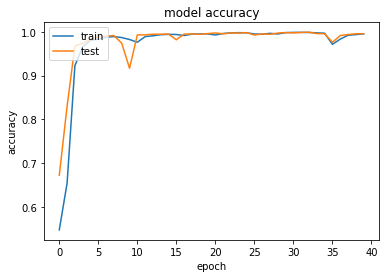

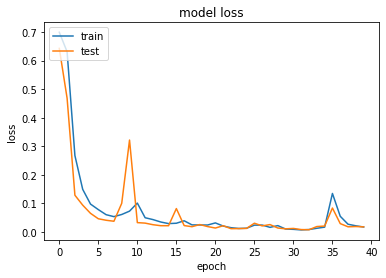

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# ROC curve

In [ ]:
from sklearn.metrics import roc_curve
y_pred_keras = model.predict(x_test).ravel()
print(y_pred_keras.shape)
y_t = y_test.ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_t, y_pred_keras)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

(4244,)


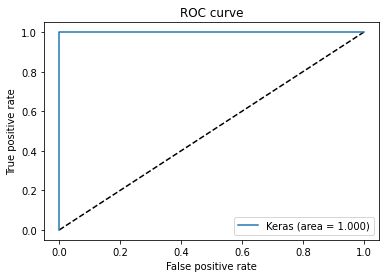

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# Testing

In [ ]:
def read_csv_test( data_url, window_size, step_size, scaler):

  data_np_windowed = []
  data_wp_windowed = []

  data_np = []
  data_wp = []

  label_data_np = []
  label_data_wp = []

  file_list  = glob.glob(data_url+'*.csv')
  for file_name in file_list:
    print(file_name)
    if (file_name.find('NP')!=-1):
      noPersonData = pd.read_csv(file_name,low_memory=False)
      noPersonData = noPersonData['CSI_DATA'].values
      noPersonData = noPersonData[1800:-1800]

      for i in range(0, noPersonData.shape[0]):
        try:
          st = noPersonData[i]
          st = st[1:-2]
          data_array = [int(s) for s in st.split(' ')]
          data_array = data_array[12:64] + data_array[66:-10]
          # print(data_array)
          data_array_mag = []
          for k in range(0,104,2):
            data_array_mag.append(sqrt(data_array[k]**2 + data_array[k+1]**2))
          # data_array_mag = running_mean(data_array_mag,5)
          # data_array_mag = scaler.fit_transform(data_array_mag)
          data_np.append(data_array_mag)
        # Pre-processing
        # data_np_window = lowpass(data_np_window,10,190,3)
        # data_np_windowed.append(data_np_window)
          # label_data_np.append(0)
        except:
          continue
    else:
      withPersonData = pd.read_csv(file_name,low_memory=False)
      withPersonData = withPersonData['CSI_DATA'].values
      withPersonData = withPersonData[1800:-1800]

      for i in range(0, withPersonData.shape[0]):
        try:
          st = withPersonData[i]
          st = st[1:-2]
          data_array = [int(s) for s in st.split(' ')]
          data_array = data_array[12:65] + data_array[67:-10]
          # print(data_array)
          data_array_mag = []
          for k in range(0,104,2):
            data_array_mag.append(sqrt(data_array[k]**2 + data_array[k+1]**2))
          # data_array_mag = running_mean(data_array_mag,5)
          # data_array_mag = scaler.fit_transform(data_array_mag)
          data_wp.append(data_array_mag)
          # Pre-processing
          # data_np_window = lowpass(data_np_window,10,190,3)
          # data_np_windowed.append(data_np_window)
          # label_data_wp.append(1)
        except:
          continue

  data_np = np.array(data_np)
  data_wp = np.array(data_wp)
  for i in range(0,52):
          data_np[:,i] = bandpass(data_np[:,i],0.2,10,192,4)
          # data_np[:,i] = running_mean(data_np[:,i],10)


  for i in range(0,52):
          data_wp[:,i] = bandpass(data_wp[:,i],0.2,10,192,4)
          # data_wp[:,i] = running_mean(data_wp[:,i],10)
  data_both = np.concatenate((data_np, data_wp), axis=0)

  data_both = scaler.transform(data_both)

  data_np = data_both[0:data_np.shape[0],:]
  data_wp = data_both[data_np.shape[0]:,:]



  for start in range(0, data_np.shape[0]-window_size, step_size):
        end = start + window_size
        data_np_window= np.empty((0,52))
        for j in range(start, end):
          data_array_mag = data_np[j]
          data_np_window = np.append(data_np_window,np.array([data_array_mag]),axis = 0)
        # for i in range(0,52):
        #   data_np_window[:,i] = bandpass(data_np_window[:,i],0.2,30,192,4)
        #   data_np_window[:,i] = running_mean(data_np_window[:,i],10)
        # data_np_window = scaler.fit_transform(data_np_window)

        data_np_windowed.append(data_np_window)
        label_data_np.append([0,1])

  for start in range(0, data_wp.shape[0]-window_size, step_size):
        end = start + window_size
        data_wp_window= np.empty((0,52))
        for j in range(start, end):
          data_array_mag = data_wp[j]
          # data_array_mag = running_mean(data_array_mag,10)
          data_wp_window = np.append(data_wp_window,np.array([data_array_mag]),axis = 0)
        # for i in range(0,52):
        #   data_wp_window[:,i] = bandpass(data_wp_window[:,i],0.2,30,192,4)
        #   data_wp_window[:,i] = running_mean(data_wp_window[:,i],10)
        # data_wp_window = scaler.fit_transform(data_wp_window)
        data_wp_windowed.append(data_wp_window)
        label_data_wp.append([1,0])

  data_np = data_np_windowed
  data_wp = data_wp_windowed


  return np.array(data_np), np.array(data_wp), np.array(label_data_np), np.array(label_data_wp), scaler


In [ ]:
test_url = '/content/gdrive/MyDrive/Presence_detection_data_CSI/Test1/'


import keras

from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
# from keras.utils import to_categorical
import tensorflow as tf
model = keras.models.load_model("best_model.h5")
window_size = 200
step_size = 100

save_url_test = '/content/gdrive/MyDrive/Presence_detection_data_CSI/Files1/'
save_url_np =  save_url_test +  'test_np_window_size={window}_step_size={step}.npy'.format(window = window_size, step = step_size)
save_url_np = Path(save_url_np)
save_url_wp = save_url_test + 'test_wp_window-size={window}_step_size={step}.npy'.format(window = window_size, step = step_size)
save_url_wp = Path(save_url_wp)

if (save_url_np.is_file() and save_url_wp.is_file()):
  test_np = np.load(save_url_np)
  test_wp = np.load(save_url_wp)
  test_label_np = np.zeros((test_np.shape[0],1))
  test_label_wp = np.zeros((test_wp.shape[0],1))
  test_label_np[:,1] = 1
  test_label_wp[:,0] = 1


else:
  file1 = 'test_np_window_size={window}_step_size={step}.npy'.format(window = window_size, step = step_size)
  file2 = 'test_wp_window-size={window}_step_size={step}.npy'.format(window = window_size, step = step_size)
  test_np, test_wp, test_label_np, test_label_wp, scaler = read_csv_test(test_url, window_size=window_size, step_size=step_size, scaler=scaler)
  np.save(file1,test_np)
  np.save(file2,test_wp)

/content/gdrive/MyDrive/Presence_detection_data_CSI/Test1/05AP-1158-110-PRABHAT-LAKSHMI-NAYAKI-01.csv
/content/gdrive/MyDrive/Presence_detection_data_CSI/Test1/05AP-1240PM-110-NP.csv
/content/gdrive/MyDrive/Presence_detection_data_CSI/Test1/Copy of 06AP-1504-736-VINAY-01.csv
/content/gdrive/MyDrive/Presence_detection_data_CSI/Test1/Copy of 10AP-2026-112-NP.csv
/content/gdrive/MyDrive/Presence_detection_data_CSI/Test1/Copy of 11AP-0024-116-ARHAM.csv
/content/gdrive/MyDrive/Presence_detection_data_CSI/Test1/Copy of 12AP-1225-736-NP.csv
/content/gdrive/MyDrive/Presence_detection_data_CSI/Test1/Copy of 11AP-0034-116-NP.csv
/content/gdrive/MyDrive/Presence_detection_data_CSI/Test1/Copy of 10AP-2032-112-BERA.csv
/content/gdrive/MyDrive/Presence_detection_data_CSI/Test1/Copy of 04AP-1740-317-NARENDRA-01.csv
/content/gdrive/MyDrive/Presence_detection_data_CSI/Test1/Copy of 11AP-1150-738-NP.csv
/content/gdrive/MyDrive/Presence_detection_data_CSI/Test1/Copy of 05AP-1330-111-JATIN-01.csv
/content

In [ ]:
# test_np = normalizer(test_np,scaler)
# test_wp = normalizer(test_wp,scaler)

test_ip = np.concatenate((test_np,test_wp),axis=0)
test_label = np.concatenate((test_label_np,test_label_wp),axis=0)

In [ ]:
test_loss, test_acc = model.evaluate(test_ip,test_label)


print(test_wp.shape[0])
print(int(test_wp.shape[0]*test_acc))
print(test_wp.shape[0]-int(test_wp.shape[0]*test_acc))

708/708 [==============================] - 29s 39ms/step - loss: 0.0774 - accuracy: 0.9860
10037
9896
141


In [ ]:
test_pred = model.predict(test_ip)
from sklearn.metrics import confusion_matrix
print(confusion_matrix(np.argmax(test_label, axis=1), np.argmax(test_pred, axis=1)))

[[10010    27]
 [  289 12325]]
